In [1]:
import os
import numpy as np

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist

from PIL import Image

/home/ivan/pybr/ajna_docs/padma/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
def view_images(imagens):
    plt.gray()
    fig=plt.figure(figsize=(16, 20))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        img = imagens[i - 1]
        ax = fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    

In [3]:
def model():
    input_img = Input(shape=(128, 128, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder


In [4]:
CAMINHO = './images'
SIZE = 128, 128
noise_factor = 0.4

def image_generator(filenames):
    for filename in filenames:
        image = Image.open('./images/' + filename)
        image = image.resize(SIZE, Image.ANTIALIAS)
        image_array = np.asarray(image).astype('float32')
        image_array = image_array[:, :, 0] / 255
        # images.append(image_array)
        image_noisy = image_array + noise_factor * \
            np.random.normal(loc=0.5, scale=0.33, size=image_array.shape)
        image_noisy = np.clip(image_noisy, 0., 1.)
        # images_noisy.append(image_noisy)
        yield image_array, image_noisy

def get_chunks(imagegenerator, chunk_size):
    images = []
    images_noisy = []
    for index in range(chunk_size):
        (image, noisy) = next(imageg)
        images.append(image)
        images_noisy.append(noisy)
        
    return images, images_noisy

dir_path = CAMINHO
extension = '.jpg'
position = len(extension)
filenames = [filename 
             for filename in os.listdir(dir_path) 
             if filename[-position:] == extension]
# filenames = filenames[:100]
imageg = image_generator(filenames)

In [5]:
CHUNK_SIZE = 16

images, images_noisy = get_chunks(imageg, CHUNK_SIZE)
print(len(images))
print(images[0].shape)
print(images_noisy[0].shape)                               

16
(128, 128)
(128, 128)


<Figure size 432x288 with 0 Axes>

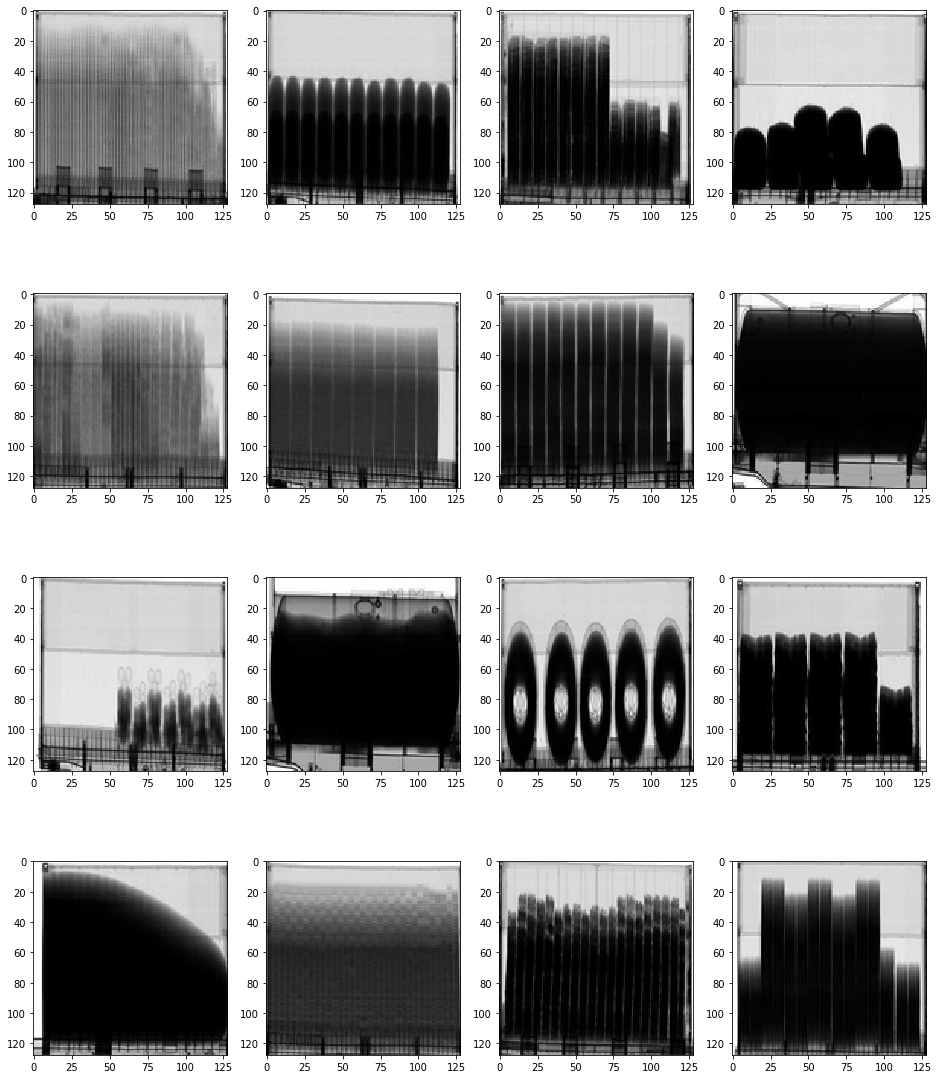

In [6]:
view_images(images)

<Figure size 432x288 with 0 Axes>

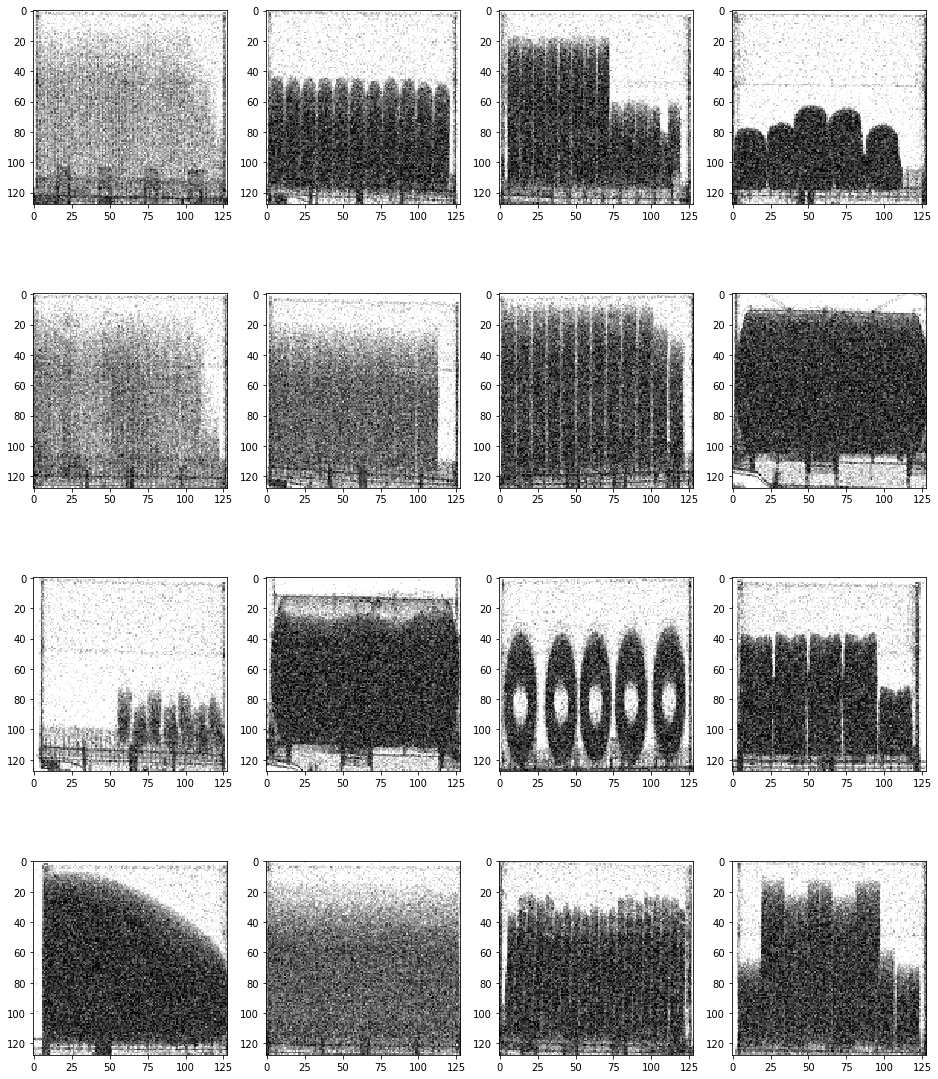

In [7]:
view_images(images_noisy)

In [8]:
y_train, x_train = get_chunks(imageg, 2000)

X_train = np.asarray(x_train)
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)
Y_train = np.asarray(y_train)
Y_train = np.expand_dims(Y_train, axis=3)
print(Y_train.shape)

(2000, 128, 128, 1)
(2000, 128, 128, 1)


In [9]:
y_test, x_test = get_chunks(imageg, 200)

X_test = np.asarray(x_test)
X_test = np.expand_dims(X_test, axis=3)
print(X_test.shape)
Y_test = np.asarray(y_test)
Y_test = np.expand_dims(Y_test, axis=3)
print(Y_test.shape)     

(200, 128, 128, 1)
(200, 128, 128, 1)


In [10]:
autoencoder = None

In [ ]:
autoencoder = load_model('autoencoder.h5')
if autoencoder is None:
    autoencoder = model()

In [11]:
autoencoder.fit(X_train, Y_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, Y_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

autoencoder.save('autoencoder.h5')

Train on 2000 samples, validate on 200 samples
Epoch 1/100
2000/2000 [==============================] - 70s 35ms/step - loss: 0.6714 - val_loss: 0.5764
Epoch 2/100
2000/2000 [==============================] - 53s 27ms/step - loss: 0.5764 - val_loss: 0.4828
Epoch 3/100
2000/2000 [==============================] - 57s 29ms/step - loss: 0.4866 - val_loss: 0.4369
Epoch 4/100
2000/2000 [==============================] - 54s 27ms/step - loss: 0.4564 - val_loss: 0.4450
Epoch 5/100
2000/2000 [==============================] - 53s 27ms/step - loss: 0.4450 - val_loss: 0.4307
Epoch 6/100
2000/2000 [==============================] - 52s 26ms/step - loss: 0.4418 - val_loss: 0.4378
Epoch 7/100
2000/2000 [==============================] - 54s 27ms/step - loss: 0.4400 - val_loss: 0.4295
Epoch 8/100
2000/2000 [==============================] - 55s 27ms/step - loss: 0.4359 - val_loss: 0.4218
Epoch 9/100
2000/2000 [==============================] - 13442s 7s/step - loss: 0.4338 - val_loss: 0.4211
Epoch 1

In [12]:
from keras.models import load_model
import numpy as np

autoencoder = load_model('autoencoder.h5')

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_denoised_images(noisy, image, original):
    plt.gray()
    fig=plt.figure(figsize=(16, 10))
    i = 0
    for r in range(1, 4):
        i += 1
        ax = fig.add_subplot(4, 3, i)
        plt.imshow(noisy[r-1])
        i += 1
        ax = fig.add_subplot(4, 3, i)
        plt.imshow(image[r-1])
        i += 1
        ax = fig.add_subplot(4, 3, i)
        plt.imshow(original[r-1])
    plt.show()



In [44]:
test_img = np.asarray([X_test[:4]])
test_img = test_img.reshape(4, 128, 128, 1)
orig_img = np.asarray([Y_test[:4]])
print(test_img.shape)
denoised_images = autoencoder.predict(test_img)
print(denoised_images.shape)


(4, 128, 128, 1)
(4, 128, 128, 1)


(4, 128, 128)
(4, 128, 128)
(4, 128, 128)


<Figure size 432x288 with 0 Axes>

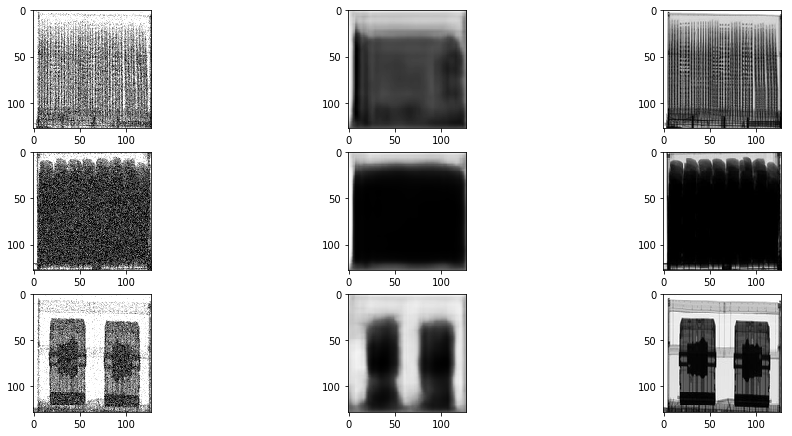

In [45]:
noisy = test_img.reshape(4, 128, 128)
print(noisy.shape)
image = denoised_images.reshape(4, 128, 128)
print(image.shape)
original = orig_img.reshape(4, 128, 128)
print(original.shape)

plot_denoised_images(noisy, image, original)

In [46]:
# Get encoder layer from trained model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

learned_codes = encoder.predict(test_img)


In [47]:
print(learned_codes.shape)
print(learned_codes)

(4, 8, 8, 8)
[[[[5.79982638e-01 9.23075974e-01 5.98771513e-01 ... 0.00000000e+00
    4.35191952e-02 0.00000000e+00]
   [4.29784000e-01 9.12304103e-01 6.62928283e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [4.36686635e-01 9.14126873e-01 6.73036456e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   ...
   [4.35284853e-01 9.54262018e-01 6.48361623e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [4.28438544e-01 9.31666076e-01 6.60504758e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [6.46100283e-01 9.82366920e-01 5.96244156e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]]

  [[8.20011139e-01 7.77693987e-01 2.21574098e-01 ... 0.00000000e+00
    4.14801121e-01 0.00000000e+00]
   [3.49032640e-01 6.69377923e-01 2.53577441e-01 ... 0.00000000e+00
    2.55785763e-01 0.00000000e+00]
   [3.76702994e-01 7.40256667e-01 2.86592007e-01 ... 0.00000000e+00
    1.06290825e-01 0.00000000e+00]
   ...
   [3.98932904e-01 7.15585053e-01 3.42566788